# MNIST with feed forward Neural Network
This notebook doesn't use GPU.

You need to install:
* anaconda (Python 3)
* conda install -c soumith pytorch 
* conda install -c soumith torchvision 

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Review: What is pytorch?

PyTorch is a popular framework for deep learning.

PyTorch consists of 4 main packages:

* torch: a general purpose array library similar to Numpy that can do computations on GPU when the tensor type is cast to (torch.cuda.TensorFloat)
* torch.autograd: a package for building a computational graph and automatically obtaining gradients
* torch.nn: a neural net library with common layers and cost functions
* torch.optim: an optimization package with common optimization algorithms like SGD,Adam, etc


## Getting the data
Here we load the dataset. In the future we will create our own datasets but MNIST dataset is part of Pytorch.

In [4]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

### Dataset

A dataset in Pytorch is a  subclass of ```torch.utils.data.Dataset```  thas has methods ```__getitem__``` and ```__len__``` methods implemented. 

In [5]:
# has length
len(train_ds)

60000

In [6]:
# you can index any element
# train_ds[0]

In [7]:
# train_ds[0] is a tuple with an image (x) and a class (y)
x, y = train_ds[0]
print(x.shape)

torch.Size([1, 28, 28])


In [8]:
print(y)

tensor(5)


### Data loader
Data loader combines a dataset and a sampler, and provides an iterator over the dataset. The data loader divides the data in mini batches. This is particularly important when working with large dataset that cannot be hold in memory. 

In [9]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False) # for test we use shuffle=False

## Looking at examples

In [10]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [11]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [12]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [13]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

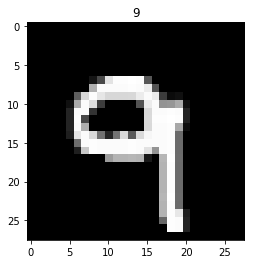

In [14]:
show(X[0][0], Y[0])

## torch.nn module
a neural net library with common layers and cost functions

### Linear layer

In [15]:
# linear transformation of a Nx5 matrix into a Nx3 matrix, where N can be anything (number of observations)
D = 5 # number of input featutes
M = 3 # neurons in the first hidden layer
linear_map = nn.Linear(D, M)

In [16]:
# parameters are initialized randomly
[p for p in linear_map.parameters()]

[Parameter containing:
 tensor([[ 0.2469,  0.2184, -0.2992,  0.3448,  0.4097],
         [-0.1085,  0.2023,  0.4396, -0.3135, -0.1455],
         [-0.0978, -0.2650,  0.0308,  0.1142,  0.2913]]), Parameter containing:
 tensor([ 0.0017,  0.1238, -0.2413])]

In [17]:
# random tensor
# think about A as a dataset with 10 points and 5 features
# the linear map with transform 
N = 10 
A = torch.randn(N, D) 
A

tensor([[-0.0926, -1.0000,  1.6144,  2.4546, -0.4632],
        [-2.0533, -2.1369,  1.1997, -1.0973, -0.4270],
        [-0.2235,  0.4419, -1.7092,  1.6288, -0.6967],
        [ 2.5760,  1.0105, -0.3007, -2.8154, -0.8766],
        [ 0.6501, -0.8153,  0.8810,  2.5546, -0.4635],
        [-0.7481,  1.2996,  0.3010,  0.1027,  2.0781],
        [-0.0145, -1.1060,  0.3728,  2.0404, -1.7696],
        [-0.5944,  0.2549, -0.5292, -0.4740, -0.4061],
        [-0.3065, -0.9603,  0.9908,  1.6842,  0.7530],
        [ 2.4662,  0.6887, -1.5430,  0.4662,  0.2807]])

In [18]:
linear_map(A)

tensor([[-0.0660, -0.0608,  0.2280],
        [-1.8845,  0.8478,  0.3131],
        [ 0.8307, -0.9232, -0.4062],
        [-0.3815,  0.9267, -1.3472],
        [ 0.4115, -0.4577,  0.0952],
        [ 0.8977,  0.2656,  0.1139],
        [-0.3765, -0.3166, -0.2177],
        [-0.2609,  0.2149, -0.4395],
        [ 0.3091, -0.2392,  0.4855],
        [ 1.4986, -0.8698, -0.5775]])

## Creating models 
There are two ways of define a model in Pytorch. 

### nn.Sequential
To create a model with nn.Sequential you provide a list of layers. For example, the following model defines a 2-layer neural network with 784 input features ($D = 784$), 300 hidden layers ($M=300$) and 10 outputs. This model uses Relu activation funtion and no final activation.

In [19]:
net = nn.Sequential(nn.Linear(784, 300),
                    nn.ReLU(),
                    nn.Linear(300, 10))

### nn.Module
A more flexible way to define models in pytorch is as a subclass of nn.Module. In the ```__init__``` method we define all layers that will be used later. In the forward method, we define the actual model using the already defined layers. Here is the same example. 

In [20]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(784, 300)
        self.linear2 = nn.Linear(300, 10)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

net = Net()

In [21]:
# this line prints all parameters
#[p for p in net.parameters()]

## Optimizer
```torch.optim``` provides implementations of commonly used optimization algorithms (such us gradient descent and momentum). You need to specify the algorithm you want to use. Adam is a popular algorithm. You also specify the parameters you want to optimize and the learning rate. If you want to use $L_2$ regularization you can specify the weight decay. Here is an example.

In [22]:
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Training loop 

In [23]:
# here is one training epoch 
def train_model(train_loader, model, optimizer):
   
    model.train() # set model to training mode
    sum_loss = 0.0
    total = 0
    for i, (images, labels) in enumerate(train_loader):   # looping through training observations
        batch = images.shape[0] # size of the batch
        images = images.view(-1, 28*28) # fattening the images
    
        pred = model(images) # prediction
        # Computing loss. Note that F.cross_entropy combines log_softmax and
        # nll_loss in a single function. That is why there is no softmax at the end of our model.
        loss = F.cross_entropy(pred, labels) 
        
        optimizer.zero_grad()  # zero the gradient buffer
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Makes an update to the parameters
        optimizer.step()
        
        total += batch
        sum_loss += batch * loss.item()
                
    train_loss = sum_loss/total
    return train_loss

## Model evaluation
Given and model and a data loader we compute loss and accuracy.

In [30]:
def model_eval(model, data_loader):
    model.eval() # set model to evaluation mode
    correct = 0   
    sum_loss = 0.0
    total = 0
    for images, labels in data_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        _, pred = torch.max(outputs.data, 1) # computes a hard prediction
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

## Training the model

In [31]:
net = Net()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.0)

In [32]:
epochs = 10
for i in range(epochs):
    train_loss = train_model(train_loader, net, optimizer)
    print("train loss ", train_loss)
    acc, loss = model_eval(net, test_loader)
    print("accuracy and test loss ", acc, loss)

train loss  0.2819532489339511
accuracy and test loss  93.9 0.2116187918946147
train loss  0.209114771267275
accuracy and test loss  94.78 0.222731652796641
train loss  0.18917332437112927
accuracy and test loss  94.25 0.2497051699474454
train loss  0.1868301212174197
accuracy and test loss  94.21 0.27098039969690146
train loss  0.17512419914230704
accuracy and test loss  94.92 0.19857247819900511
train loss  0.1716309383617093
accuracy and test loss  93.93 0.3154376177391037
train loss  0.16212673492059113
accuracy and test loss  94.18 0.2565289742290974
train loss  0.1562506328223894
accuracy and test loss  95.59 0.22041507729638835
train loss  0.15083103455857685
accuracy and test loss  95.06 0.21142924510817976
train loss  0.15740459418514122
accuracy and test loss  95.89 0.24820291886106133


## Lab
* Extend the model to a 3-layer neural network.
* Modify the training by starting with 0.01 learning rate for 5 epochs and then lowering learning rate to 0.001 for another 5 epochs.
* Write a function that computes F1 score.
* Change the optimizer to train with gradient descent with momemtum (instead of Adam). 
* How much can you increase the batch size and be able to train in your laptop?

## References

* https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim
* https://hsaghir.github.io/data_science/pytorch_starter/

Note that the 0.4 version of Pytorch had a few changes.
https://pytorch.org/2018/04/22/0_4_0-migration-guide.html